cuda:0
4096


D:\Programmieren\Python\deep-expander-networks-python-code\fixedexpandergraphlayer.py:92: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(self.weight.data,mode='fan_in')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


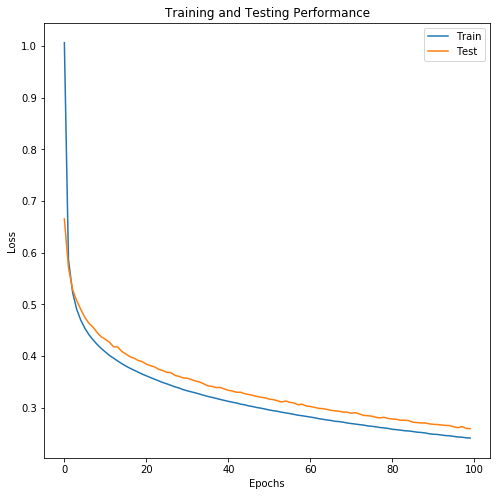

In [2]:
import random
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

from fixedexpandergraphlayer import ExpanderLinear

#Set Network Type
network_type_name = "Dense" #"Dense","LRBG","Exponential Expander","Linear Expander"

def plot_hist(epochs, tr_loss, t_loss,  xsize, ysize):
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True)
    plt.plot(tr_loss)
    plt.plot(t_loss)
    plt.title('Training and Testing Performance')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Test'], loc='best')
    plt.draw()
    plt.show()
    return

random.seed()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#Fetching Data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])])
training = datasets.FashionMNIST('~/datasets/F_MNIST/',
                                 download=True,
                                 train=True,
                                 transform=transform)
training_batches = torch.utils.data.DataLoader(training,
                                               batch_size=64,
                                               shuffle=True)
testing = datasets.FashionMNIST('~/datasets/F_MNIST/',
                                download=True,
                                train=False,
                                transform=transform)
test_batches = torch.utils.data.DataLoader(testing,
                                           batch_size=64,
                                           shuffle=True)


#Learning Parameters
learning_rate = 0.005
rows = 1
epochs = 100



#General network parameters
input_size = 28*28
output_size = 10
hidden_size=64


if network_type_name== "Dense":
    edges_per_node=64
    number_of_layers=1
    Mask=torch.ones(hidden_size,hidden_size)
    number_of_inner_edges=hidden_size*edges_per_node
if network_type_name== "LRBG":
    edges_per_node=32
    number_of_layers=2
    number_of_inner_edges=0
    Mask=torch.zeros(hidden_size,hidden_size)
    for n in range(hidden_size):
            perm = torch.randperm(hidden_size)
            for d in range(edges_per_node):
                Mask[perm[d]][n] = 1
                number_of_inner_edges=number_of_inner_edges+1
if network_type_name== "Linear Expander":
    edges_per_node=32
    number_of_layers=2
    number_of_inner_edges=0
    Mask=torch.zeros(hidden_size,hidden_size)
    for n in range(hidden_size):
            for d in range(edges_per_node):
                Mask[(n+d)%hidden_size][n] = 1
                number_of_inner_edges=number_of_inner_edges+1
if network_type_name== "Exponential Expander":
    edges_per_node=32
    number_of_layers=2
    number_of_inner_edges=0
    Mask=torch.zeros(hidden_size,hidden_size)
    index=0
    for n in range(hidden_size):
            for d in range(edges_per_node):
                Mask[index][n] = 1
                index=(index+1)%hidden_size
                number_of_inner_edges=number_of_inner_edges+1

number_of_inner_edges=number_of_inner_edges*number_of_layers
print(number_of_inner_edges)

model_list=[]
model_list.append(nn.Linear(input_size, hidden_size))
model_list.append(nn.ReLU())

for l in range(number_of_layers):
    ExpanderLinear(hidden_size ,hidden_size , Mask)
    model_list.append(nn.ReLU())

model_list.append(nn.Linear(hidden_size, output_size))
model_list.append(nn.LogSoftmax(dim=rows))
model = nn.Sequential(*model_list)
model.cuda()
model

# model = nn.Sequential(
#    nn.Linear(input_size, hidden_size),
#    nn.ReLU(),
#    ExpanderLinear(hidden_size ,hidden_size , Mask),
#    nn.ReLU(),
#    nn.Linear(hidden_size, output_size),
#    nn.LogSoftmax(dim = rows)
# )
# model.cuda()

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
train_loss = []
test_loss = []
for epoch in range(epochs):
  print(epoch)
  running_loss = 0
  running_loss1 =0
  for images, labels in training_batches:
    images = images.to(device)
    labels = labels.to(device)
        # some setup
        ## Flatten the images
    images = images.view(images.shape[0], -1)
        ## Reset the optimizer
    optimizer.zero_grad()

        # forward pass
    output = model.forward(images)

        # back-propagation
    loss = criterion(output, labels)
    loss.backward()

        # take the next step
    optimizer.step()
    running_loss += loss.item()
  train_loss.append(running_loss / len(training_batches))
  for images1, labels1 in test_batches:
    images1 = images1.to(device)
    labels1 = labels1.to(device)
        # some setup
        ## Flatten the images
    images1 = images1.view(images1.shape[0], -1)
        ## Reset the optimizer
    optimizer.zero_grad()

        # forward pass
    output1 = model.forward(images1)

        # back-propagation
    loss1 = criterion(output1, labels1)
    loss1.backward()

        # take the next step
    optimizer.step()
    running_loss1 += loss1.item()
  test_loss.append(running_loss1 / len(test_batches))
plot_hist(epochs, train_loss, test_loss, xsize=8, ysize=8)

cuda:0
4096
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


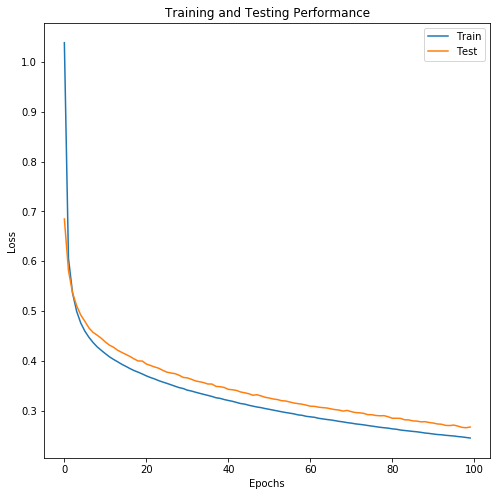

In [3]:
import random
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

from fixedexpandergraphlayer import ExpanderLinear

#Set Network Type
network_type_name = "LRBG" #"Dense","LRBG","Exponential Expander","Linear Expander"

def plot_hist(epochs, tr_loss, t_loss,  xsize, ysize):
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True)
    plt.plot(tr_loss)
    plt.plot(t_loss)
    plt.title('Training and Testing Performance')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Test'], loc='best')
    plt.draw()
    plt.show()
    return

random.seed()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#Fetching Data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])])
training = datasets.FashionMNIST('~/datasets/F_MNIST/',
                                 download=True,
                                 train=True,
                                 transform=transform)
training_batches = torch.utils.data.DataLoader(training,
                                               batch_size=64,
                                               shuffle=True)
testing = datasets.FashionMNIST('~/datasets/F_MNIST/',
                                download=True,
                                train=False,
                                transform=transform)
test_batches = torch.utils.data.DataLoader(testing,
                                           batch_size=64,
                                           shuffle=True)


#Learning Parameters
learning_rate = 0.005
rows = 1
epochs = 100



#General network parameters
input_size = 28*28
output_size = 10
hidden_size=64


if network_type_name== "Dense":
    edges_per_node=64
    number_of_layers=1
    Mask=torch.ones(hidden_size,hidden_size)
    number_of_inner_edges=hidden_size*edges_per_node
if network_type_name== "LRBG":
    edges_per_node=32
    number_of_layers=2
    number_of_inner_edges=0
    Mask=torch.zeros(hidden_size,hidden_size)
    for n in range(hidden_size):
            perm = torch.randperm(hidden_size)
            for d in range(edges_per_node):
                Mask[perm[d]][n] = 1
                number_of_inner_edges=number_of_inner_edges+1
if network_type_name== "Linear Expander":
    edges_per_node=32
    number_of_layers=2
    number_of_inner_edges=0
    Mask=torch.zeros(hidden_size,hidden_size)
    for n in range(hidden_size):
            for d in range(edges_per_node):
                Mask[(n+d)%hidden_size][n] = 1
                number_of_inner_edges=number_of_inner_edges+1
if network_type_name== "Exponential Expander":
    edges_per_node=32
    number_of_layers=2
    number_of_inner_edges=0
    Mask=torch.zeros(hidden_size,hidden_size)
    index=0
    for n in range(hidden_size):
            for d in range(edges_per_node):
                Mask[index][n] = 1
                index=(index+1)%hidden_size
                number_of_inner_edges=number_of_inner_edges+1

number_of_inner_edges=number_of_inner_edges*number_of_layers
print(number_of_inner_edges)

model_list=[]
model_list.append(nn.Linear(input_size, hidden_size))
model_list.append(nn.ReLU())

for l in range(number_of_layers):
    ExpanderLinear(hidden_size ,hidden_size , Mask)
    model_list.append(nn.ReLU())

model_list.append(nn.Linear(hidden_size, output_size))
model_list.append(nn.LogSoftmax(dim=rows))
model = nn.Sequential(*model_list)
model.cuda()
model

# model = nn.Sequential(
#    nn.Linear(input_size, hidden_size),
#    nn.ReLU(),
#    ExpanderLinear(hidden_size ,hidden_size , Mask),
#    nn.ReLU(),
#    nn.Linear(hidden_size, output_size),
#    nn.LogSoftmax(dim = rows)
# )
# model.cuda()

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
train_loss = []
test_loss = []
for epoch in range(epochs):
  print(epoch)
  running_loss = 0
  running_loss1 =0
  for images, labels in training_batches:
    images = images.to(device)
    labels = labels.to(device)
        # some setup
        ## Flatten the images
    images = images.view(images.shape[0], -1)
        ## Reset the optimizer
    optimizer.zero_grad()

        # forward pass
    output = model.forward(images)

        # back-propagation
    loss = criterion(output, labels)
    loss.backward()

        # take the next step
    optimizer.step()
    running_loss += loss.item()
  train_loss.append(running_loss / len(training_batches))
  for images1, labels1 in test_batches:
    images1 = images1.to(device)
    labels1 = labels1.to(device)
        # some setup
        ## Flatten the images
    images1 = images1.view(images1.shape[0], -1)
        ## Reset the optimizer
    optimizer.zero_grad()

        # forward pass
    output1 = model.forward(images1)

        # back-propagation
    loss1 = criterion(output1, labels1)
    loss1.backward()

        # take the next step
    optimizer.step()
    running_loss1 += loss1.item()
  test_loss.append(running_loss1 / len(test_batches))
plot_hist(epochs, train_loss, test_loss, xsize=8, ysize=8)

cuda:0
4096
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


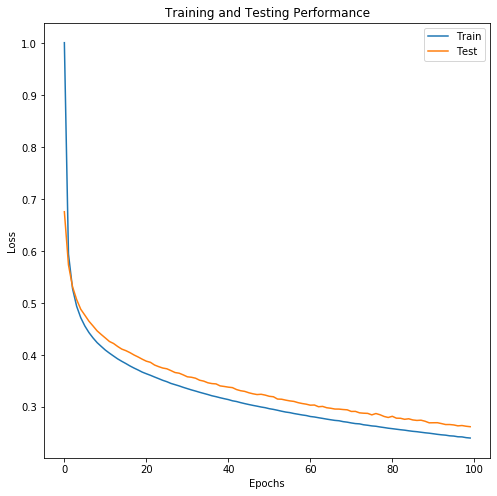

In [5]:
import random
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

from fixedexpandergraphlayer import ExpanderLinear

#Set Network Type
network_type_name = "Exponential Expander" #"Dense","LRBG","Exponential Expander","Linear Expander"

def plot_hist(epochs, tr_loss, t_loss,  xsize, ysize):
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True)
    plt.plot(tr_loss)
    plt.plot(t_loss)
    plt.title('Training and Testing Performance')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Test'], loc='best')
    plt.draw()
    plt.show()
    return

random.seed()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#Fetching Data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])])
training = datasets.FashionMNIST('~/datasets/F_MNIST/',
                                 download=True,
                                 train=True,
                                 transform=transform)
training_batches = torch.utils.data.DataLoader(training,
                                               batch_size=64,
                                               shuffle=True)
testing = datasets.FashionMNIST('~/datasets/F_MNIST/',
                                download=True,
                                train=False,
                                transform=transform)
test_batches = torch.utils.data.DataLoader(testing,
                                           batch_size=64,
                                           shuffle=True)


#Learning Parameters
learning_rate = 0.005
rows = 1
epochs = 100



#General network parameters
input_size = 28*28
output_size = 10
hidden_size=64


if network_type_name== "Dense":
    edges_per_node=64
    number_of_layers=1
    Mask=torch.ones(hidden_size,hidden_size)
    number_of_inner_edges=hidden_size*edges_per_node
if network_type_name== "LRBG":
    edges_per_node=32
    number_of_layers=2
    number_of_inner_edges=0
    Mask=torch.zeros(hidden_size,hidden_size)
    for n in range(hidden_size):
            perm = torch.randperm(hidden_size)
            for d in range(edges_per_node):
                Mask[perm[d]][n] = 1
                number_of_inner_edges=number_of_inner_edges+1
if network_type_name== "Linear Expander":
    edges_per_node=32
    number_of_layers=2
    number_of_inner_edges=0
    Mask=torch.zeros(hidden_size,hidden_size)
    for n in range(hidden_size):
            for d in range(edges_per_node):
                Mask[(n+d)%hidden_size][n] = 1
                number_of_inner_edges=number_of_inner_edges+1
if network_type_name== "Exponential Expander":
    edges_per_node=32
    number_of_layers=2
    number_of_inner_edges=0
    Mask=torch.zeros(hidden_size,hidden_size)
    index=0
    for n in range(hidden_size):
            for d in range(edges_per_node):
                Mask[index][n] = 1
                index=(index+1)%hidden_size
                number_of_inner_edges=number_of_inner_edges+1

number_of_inner_edges=number_of_inner_edges*number_of_layers
print(number_of_inner_edges)

model_list=[]
model_list.append(nn.Linear(input_size, hidden_size))
model_list.append(nn.ReLU())

for l in range(number_of_layers):
    ExpanderLinear(hidden_size ,hidden_size , Mask)
    model_list.append(nn.ReLU())

model_list.append(nn.Linear(hidden_size, output_size))
model_list.append(nn.LogSoftmax(dim=rows))
model = nn.Sequential(*model_list)
model.cuda()
model

# model = nn.Sequential(
#    nn.Linear(input_size, hidden_size),
#    nn.ReLU(),
#    ExpanderLinear(hidden_size ,hidden_size , Mask),
#    nn.ReLU(),
#    nn.Linear(hidden_size, output_size),
#    nn.LogSoftmax(dim = rows)
# )
# model.cuda()

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
train_loss = []
test_loss = []
for epoch in range(epochs):
  print(epoch)
  running_loss = 0
  running_loss1 =0
  for images, labels in training_batches:
    images = images.to(device)
    labels = labels.to(device)
        # some setup
        ## Flatten the images
    images = images.view(images.shape[0], -1)
        ## Reset the optimizer
    optimizer.zero_grad()

        # forward pass
    output = model.forward(images)

        # back-propagation
    loss = criterion(output, labels)
    loss.backward()

        # take the next step
    optimizer.step()
    running_loss += loss.item()
  train_loss.append(running_loss / len(training_batches))
  for images1, labels1 in test_batches:
    images1 = images1.to(device)
    labels1 = labels1.to(device)
        # some setup
        ## Flatten the images
    images1 = images1.view(images1.shape[0], -1)
        ## Reset the optimizer
    optimizer.zero_grad()

        # forward pass
    output1 = model.forward(images1)

        # back-propagation
    loss1 = criterion(output1, labels1)
    loss1.backward()

        # take the next step
    optimizer.step()
    running_loss1 += loss1.item()
  test_loss.append(running_loss1 / len(test_batches))
plot_hist(epochs, train_loss, test_loss, xsize=8, ysize=8)

cuda:0
4096
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


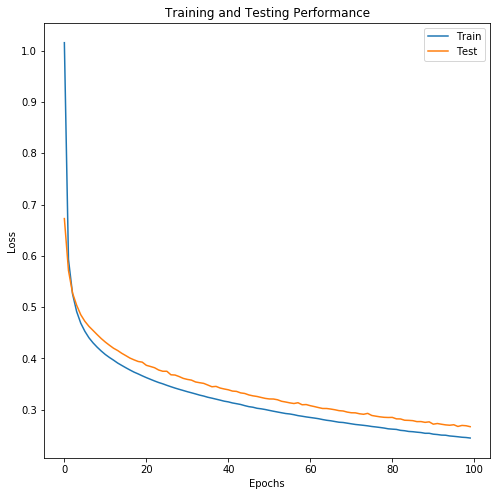

In [4]:
import random
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

from fixedexpandergraphlayer import ExpanderLinear

#Set Network Type
network_type_name = "Linear Expander" #"Dense","LRBG","Exponential Expander","Linear Expander"

def plot_hist(epochs, tr_loss, t_loss,  xsize, ysize):
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True)
    plt.plot(tr_loss)
    plt.plot(t_loss)
    plt.title('Training and Testing Performance')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Test'], loc='best')
    plt.draw()
    plt.show()
    return

random.seed()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#Fetching Data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])])
training = datasets.FashionMNIST('~/datasets/F_MNIST/',
                                 download=True,
                                 train=True,
                                 transform=transform)
training_batches = torch.utils.data.DataLoader(training,
                                               batch_size=64,
                                               shuffle=True)
testing = datasets.FashionMNIST('~/datasets/F_MNIST/',
                                download=True,
                                train=False,
                                transform=transform)
test_batches = torch.utils.data.DataLoader(testing,
                                           batch_size=64,
                                           shuffle=True)


#Learning Parameters
learning_rate = 0.005
rows = 1
epochs = 100



#General network parameters
input_size = 28*28
output_size = 10
hidden_size=64


if network_type_name== "Dense":
    edges_per_node=64
    number_of_layers=1
    Mask=torch.ones(hidden_size,hidden_size)
    number_of_inner_edges=hidden_size*edges_per_node
if network_type_name== "LRBG":
    edges_per_node=32
    number_of_layers=2
    number_of_inner_edges=0
    Mask=torch.zeros(hidden_size,hidden_size)
    for n in range(hidden_size):
            perm = torch.randperm(hidden_size)
            for d in range(edges_per_node):
                Mask[perm[d]][n] = 1
                number_of_inner_edges=number_of_inner_edges+1
if network_type_name== "Linear Expander":
    edges_per_node=32
    number_of_layers=2
    number_of_inner_edges=0
    Mask=torch.zeros(hidden_size,hidden_size)
    for n in range(hidden_size):
            for d in range(edges_per_node):
                Mask[(n+d)%hidden_size][n] = 1
                number_of_inner_edges=number_of_inner_edges+1
if network_type_name== "Exponential Expander":
    edges_per_node=32
    number_of_layers=2
    number_of_inner_edges=0
    Mask=torch.zeros(hidden_size,hidden_size)
    index=0
    for n in range(hidden_size):
            for d in range(edges_per_node):
                Mask[index][n] = 1
                index=(index+1)%hidden_size
                number_of_inner_edges=number_of_inner_edges+1

number_of_inner_edges=number_of_inner_edges*number_of_layers
print(number_of_inner_edges)

model_list=[]
model_list.append(nn.Linear(input_size, hidden_size))
model_list.append(nn.ReLU())

for l in range(number_of_layers):
    ExpanderLinear(hidden_size ,hidden_size , Mask)
    model_list.append(nn.ReLU())

model_list.append(nn.Linear(hidden_size, output_size))
model_list.append(nn.LogSoftmax(dim=rows))
model = nn.Sequential(*model_list)
model.cuda()
model

# model = nn.Sequential(
#    nn.Linear(input_size, hidden_size),
#    nn.ReLU(),
#    ExpanderLinear(hidden_size ,hidden_size , Mask),
#    nn.ReLU(),
#    nn.Linear(hidden_size, output_size),
#    nn.LogSoftmax(dim = rows)
# )
# model.cuda()

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
train_loss = []
test_loss = []
for epoch in range(epochs):
  print(epoch)
  running_loss = 0
  running_loss1 =0
  for images, labels in training_batches:
    images = images.to(device)
    labels = labels.to(device)
        # some setup
        ## Flatten the images
    images = images.view(images.shape[0], -1)
        ## Reset the optimizer
    optimizer.zero_grad()

        # forward pass
    output = model.forward(images)

        # back-propagation
    loss = criterion(output, labels)
    loss.backward()

        # take the next step
    optimizer.step()
    running_loss += loss.item()
  train_loss.append(running_loss / len(training_batches))
  for images1, labels1 in test_batches:
    images1 = images1.to(device)
    labels1 = labels1.to(device)
        # some setup
        ## Flatten the images
    images1 = images1.view(images1.shape[0], -1)
        ## Reset the optimizer
    optimizer.zero_grad()

        # forward pass
    output1 = model.forward(images1)

        # back-propagation
    loss1 = criterion(output1, labels1)
    loss1.backward()

        # take the next step
    optimizer.step()
    running_loss1 += loss1.item()
  test_loss.append(running_loss1 / len(test_batches))
plot_hist(epochs, train_loss, test_loss, xsize=8, ysize=8)